## Mode Solver

This tutorial shows how to use the mode solver plugin in tidy3d.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('..')

import tidy3d as td
from tidy3d.constants import C_0

## Setup

We first set up the mode solver with information about our system.

We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = .05

# waveguide information 
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# frequency we want to solve at (freq0)
wvl_um = 2.0
freq_hz = C_0 / wvl_um

Then we set up a simulation, in this case including a straight waveguide

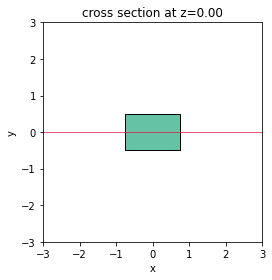

In [3]:
waveguide = td.Structure(
    geometry = td.Box(size=(wg_width, wg_height, Lz)),
    medium = td.Medium(permittivity=wg_permittivity)
)
monitor = td.FieldMonitor(
    size=(Lx, 0, Lz),
    freqs=[freq_hz],
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=1e-12,
    pml_layers=(None, None, None),
    structures=[waveguide],
    monitors={'field': monitor}
)

ax = sim.plot(z=0)

## Initialize Mode Solver

With our system defined, we can now create our mode solver.

We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(
    center=(0,0,0),
    size=(Lx/3, Ly/3, 0)
)

Then we can initialize a `ModeSolver()` object to solve for the modes at frequency `freq` on plane `plane` in `sim`.

The mode solver will evaluate the complex-valued permittivity of `simulation` on `plane` at frequency `freq` and use this for the mode solver.

In [5]:
from tidy3d.plugins import ModeSolver

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq_hz
)

## Define Mode

The goal of the mode solver is to determine a `td.Mode()` specification that can be used in your actual Tidy3d simulation.

We can define such a specification using

- `mode_index`: integer (return the `mode_index`-th result of the solver, generally this refers to the mode with the `mode_index`-th lowest effective index.

- `target_neff`: float, default=None, guess for the n_eff of the mode, if not specified, chooses the maximum real part of the refractive index in the cross section.

- `symmetry`: tuple of 2 integers, default=(0,0), with the first and second value being one of {0: no symmetry, 1: PMC (even), -1: PEC (odd)}.  These set the symmetry on the two axes of the plane.

- `num_pml`: tuple of 2 integers, default=(0,0) specifying how many pml layers to place on the two axes of the plane.

For example:

In [6]:
mode = td.Mode(
    mode_index=0,
    num_modes=2,
    target_neff=2.0,
    symmetries=(0,0),
    num_pml=(0,0)
)

Once we have the mode specification, we can `solve` for the mode information using our `ModeSolver()` instance.

In [7]:
mode_info = mode_solver.solve(mode)

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles.

The effective index information can be accessed as follows.

In [8]:
n_eff = mode_info.n_eff
k_eff = mode_info.k_eff

print(f'found: n_eff = {n_eff:.2f}, k_eff = {k_eff:.2e}')

found: n_eff = 1.74, k_eff = 1.31e-17


The `mode_info.field_data` attribute is a `td.FieldData` instance that can be visualized and analyzed using the various methods provided by `FieldData` objects.

In [9]:
mode_info.field_data.coords

Coordinates:
  * x        (x) float64 -1.0 -0.95 -0.9 -0.85 -0.8 ... 0.8 0.85 0.9 0.95 1.0
  * y        (y) float64 -1.0 -0.95 -0.9 -0.85 -0.8 ... 0.8 0.85 0.9 0.95 1.0
  * z        (z) float64 0.0
  * f        (f) float64 1.499e+14

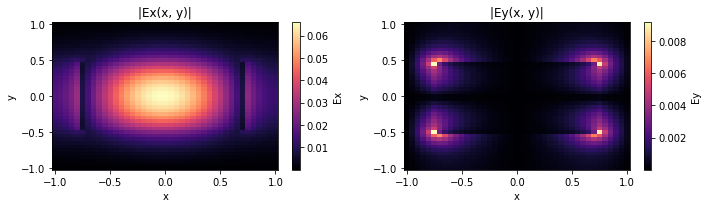

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(mode_info.field_data.Ex).plot(x='x', y='y', cmap='magma', ax=ax1)
abs(mode_info.field_data.Ey).plot(x='x', y='y', cmap='magma', ax=ax2)
ax1.set_title('|Ex(x, y)|')
ax2.set_title('|Ey(x, y)|')
plt.show()

## Refining the Mode information

In typical settings, one would want to tweak the parameters in the `Mode` specification nd run again.

For example, if we wanted to find the next higher order mode, we can adjust `Mode.mode_index` and solve again.

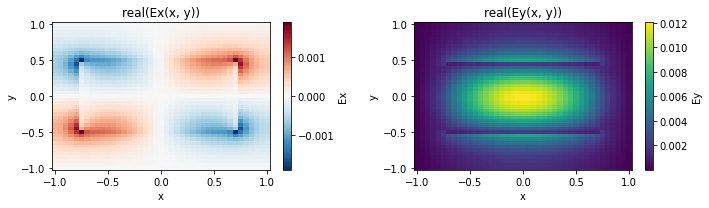

In [11]:
mode.mode_index=1
mode_info = mode_solver.solve(mode)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_info.field_data.Ex.real.plot(x='x', y='y', ax=ax1)
mode_info.field_data.Ey.real.plot(x='x', y='y', ax=ax2)
ax1.set_title('real(Ex(x, y))')
ax2.set_title('real(Ey(x, y))')
plt.show()

This looks like an Ey-dominant mode, if instead we wanted a higher order Ex-dominant mode, let's try again with `mode_index=3`.

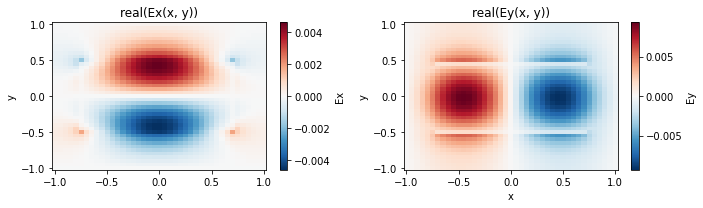

In [12]:
mode.mode_index = 3
mode.num_modes = 4 # make sure we specify that we want solver return enough modes to cover mode_index=3
mode_info = mode_solver.solve(mode)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_info.field_data.Ex.real.plot(x='x', y='y', ax=ax1)
mode_info.field_data.Ey.real.plot(x='x', y='y', ax=ax2)
ax1.set_title('real(Ex(x, y))')
ax2.set_title('real(Ey(x, y))')
plt.show()

## Exporting Results

This looks promising!

Now we may want to export this `Mode` specification to use in our main tidy3d script.

There are several ways to do this:

### As Source
The `Mode` object used in the `ModeSolver` can be used directly to define a `ModeSource` or `ModeMonitor`, for example:

In [13]:
mode.mode_index = 0
mode.num_modes = 1
mode_source = mode_solver.make_source(mode, fwidth=freq_hz/10, direction='+')

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=1e-12,
    pml_layers=(td.PML(), td.PML(), td.PML()),
    structures=[waveguide],
    sources={'mode': mode_source},
    monitors={'field': monitor}
)

In [14]:
import tidy3d.web as web
job = web.Job(simulation=sim, task_name='mode_simulation')
sim_data = job.run(path='data/simulation_data.hdf5')

[13:34:25] INFO     Creating task.                                              ]8;id=25226;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:329

           INFO     Uploading the json file                                     ]8;id=814517;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:338

Output()

[13:34:39] status = preprocess                                               ]8;id=213574;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[13:35:02] status = running                                                  ]8;id=919581;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[13:35:24] status = visualize                                                ]8;id=750818;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[13:35:29] status = success                                                  ]8;id=916679;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/tidy3d/web/container.py\container.py]8;;\:101

[13:35:29] INFO     clearing existing files before downloading                  ]8;id=353397;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:220

           INFO     downloading file "simulation.json" to                       ]8;id=604351;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:371
                    "data/simulation.json"

Output()

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=329181;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:371
                    "data/monitor_data.hdf5"

Output()

[13:35:30] INFO     getting log string                                          ]8;id=775041;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:229

           INFO     downloading file "tidy3d.log" to "data/tidy3d.log"          ]8;id=509357;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:371

Output()

           INFO     loading old monitor data to data dict                       ]8;id=965791;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:234

           INFO     creating SimulationData from monitor data dict              ]8;id=815811;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:239

           INFO     exporting SimulationData to data/simulation_data.hdf5       ]8;id=69946;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:246

           INFO     clearing extraneous files                                   ]8;id=447994;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:249

           INFO     removing file data/simulation.json                          ]8;id=717170;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:402

           INFO     removing file data/monitor_data.hdf5                        ]8;id=340802;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:402

           INFO     removing file data/tidy3d.log                               ]8;id=926939;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:402

           INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=298453;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/web/webapi.py\webapi.py]8;;\:280

<matplotlib.collections.QuadMesh object at 0x1290809a0>

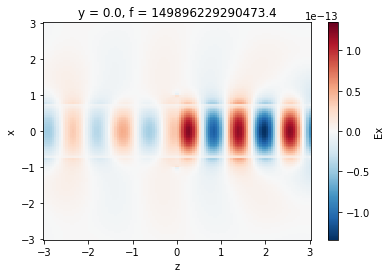

In [15]:
sim_data['field'].Ex.real.plot()

### Save and Load
Like most tidy3d components, the `mode` can be exported to .json and loaded in your main script, if runnning mode solver as a separate program.

In [16]:
# save to file
fname = 'data/mode.json'
mode.export(fname)

# in your main script, load file and use mode
mode = td.Mode.load(fname)

### Copy and Paste

One can also simply print the mode and copy and paste this information into the main script to hard-code the specifications

In [17]:
print(f'mode = td.Mode({mode})')

mode = td.Mode(mode_index=0 num_modes=1 target_neff=2.0 symmetries=(0, 0) num_pml=(0, 0))


In [18]:
# copy and paste output in your file
mode = td.Mode(mode_index=2)

### ModeSolver methods
Finally, the `ModeSolver` provides some convenience methods for returning `ModeSource` and `ModeMonitor` objects.

In [19]:
# makes a modal source with geometry of `plane`, source_time given by `freq_hz` and `fwidth` and `mode` specified by `mode`
mode_src = mode_solver.make_source(mode=mode, fwidth=freq_hz, direction='+')

# makes a mode monitor with geometry of `plane`, `td.FreqSampler` given by a list of frequencies and `mode` specified by `mode`
mode_mon = mode_solver.make_monitor(mode=mode, freqs=[0.9 * freq_hz, freq_hz, 1.1*freq_hz])


## Advanced Use

Here are some more advanced functionalities of the mode solver for practical use:

### "Scanning" modes
One might want to view how a mode behaves over a range of frequencies, for now, just iterate:

freq = 600 THz
	- neff = 1.96
	- keff = -7.51e-20


freq = 400 THz
	- neff = 1.91
	- keff = 2.02e-11
freq = 300 THz
	- neff = 1.84
	- keff = -2.09e-11


freq = 240 THz
	- neff = 1.76
	- keff = 3.30e-11


freq = 200 THz
	- neff = 1.65
	- keff = -1.02e-17


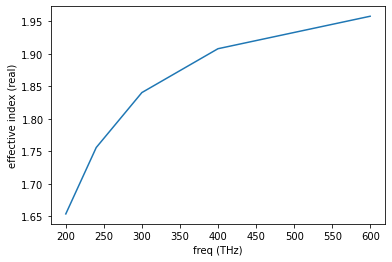

In [20]:
freqs = C_0 / np.linspace(0.5, 1.5, 5)
neffs = []
for freq in freqs:
    mode_solver = ModeSolver(
        simulation=sim,
        plane=plane,
        freq=freq)
    mode_info = mode_solver.solve(mode)
    print(f'freq = {(freq/1e12):.0f} THz\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

### Viewing multiple mode specifications
One might want to view multiple mode specifications side by side, for now, just iterate:

mode index = 0
	- neff = 1.84
	- keff = 2.77e-19
mode index = 1
	- neff = 1.81
	- keff = -3.81e-16
mode index = 2
	- neff = 1.65
	- keff = 3.23e-17


mode index = 3
	- neff = 1.64
	- keff = -8.18e-18
mode index = 4
	- neff = 1.53
	- keff = 5.92e-14


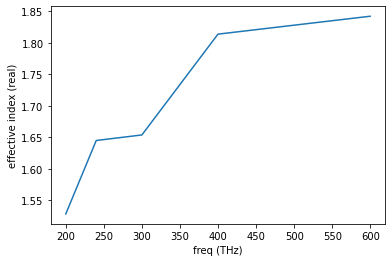

In [21]:
mode_indices = np.arange(0, 5)
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq)

neffs = []
for mode_index in mode_indices:
    mode = td.Mode(mode_index=mode_index)
    mode_info = mode_solver.solve(mode)
    print(f'mode index = {mode_index}\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothening, even if this is specified in the simulation.  Therefore, the results might not perfectly match what we compute with `simulation.subpixel=True`.
- Symmetries are applied to the cross section of the permittivity parsed from the simulation.  It uses the upper quadrant data to fill the full `plane`.  